In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

class HeartRiskMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 32) # Fewer neurons = less memorization
        self.bn1 = nn.BatchNorm1d(32)
        self.dropout = nn.Dropout(0.2)      # 20% Dropout
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [37]:
def train_heart_model(model, train_tensors, epochs=200, lr=0.005, loss_limit=0.15):
    X_train, y_train = train_tensors
    # weight_decay adds L2 Regularization
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)
    criterion = nn.BCELoss()
    
    print(f"--- Training with Loss Floor: {loss_limit} ---")
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
        # STOP if loss hits the floor you requested
        if loss.item() <= loss_limit:
            print(f'Iteration [{epoch+1}/{epochs}] | Loss reached limit: {loss.item():.4f}')
            break
            
        if (epoch + 1) % 20 == 0 or epoch == 0:
            print(f'Iteration [{epoch+1}/{epochs}] | Loss: {loss.item():.4f}')
            
    print("Training Complete.\n")
    return model

# Initialize and Train
model = HeartRiskMLP(input_dim=train_data[0].shape[1])
model = train_heart_model(model, train_data, epochs=200, lr=0.005, loss_limit=0.15)

--- Training with Loss Floor: 0.15 ---
Iteration [1/200] | Loss: 0.6901
Iteration [20/200] | Loss: 0.3733
Iteration [40/200] | Loss: 0.2467
Iteration [60/200] | Loss: 0.1775
Iteration [73/200] | Loss reached limit: 0.1391
Training Complete.



In [46]:
def generate_risk_report(risk_prob):
    """Categorizes the probability into clinical tiers."""
    percentage = risk_prob * 100
    
    if percentage < 20:
        tier = "LOW"
        color = "\033[92m" # Green
        advice = "Continue regular check-ups and a healthy lifestyle."
    elif 20 <= percentage < 50:
        tier = "MODERATE"
        color = "\033[93m" # Yellow
        advice = "Consult a physician to discuss risk factor management (Diet/Exercise)."
    elif 50 <= percentage < 80:
        tier = "HIGH"
        color = "\033[94m" # Blue/Purple
        advice = "Medical evaluation recommended. Potential for preventive intervention."
    else:
        tier = "VERY HIGH"
        color = "\033[91m" # Red
        advice = "Immediate clinical consultation advised. High correlation with heart disease patterns."
    
    reset = "\033[0m"
    
    print("\n" + "="*45)
    print(f"       PATIENT HEALTH RISK REPORT")
    print("="*45)
    print(f" CALCULATED RISK: {percentage:.2f}%")
    print(f" CLINICAL TIER:   {color}{tier}{reset}")
    print("-"*45)
    print(f" RECOMMENDATION:  {advice}")
    print("="*45)

# --- Updated Execution Block ---

# 1. Get input (Manual with Validator or Default)
mode = input("\nEnter '1' for manual input with validator, or '2' for default: ")
if mode == '1':
    patient_data = get_validated_input() # Using the validator function from previous turn
else:
    # Example Moderate-Risk Profile
    patient_data = {
        'age': 58.0, 'sex': 1.0, 'chest_pain_type': 3.0, 'resting_blood_pressure': 130.0,
        'serum_cholestoral': 240.0, 'fasting_blood_sugar': 0.0, 'resting_ecg': 1.0,
        'max_heart_rate': 140.0, 'exercise_induced_angina': 0.0, 'oldpeak': 1.0,
        'st_slope': 1.0, 'major_vessels_count': 1.0, 'thal': 3.0
    }

# 2. Get Probability
risk_prob = predict_patient_risk(model, preprocessor, patient_data, original_columns)

# 3. Print the Final Report
generate_risk_report(risk_prob)


Enter '1' for manual input with validator, or '2' for default:  2


Debug - Raw Model Score: -1.9379

       PATIENT HEALTH RISK REPORT
 CALCULATED RISK: 12.59%
 CLINICAL TIER:   LOW
---------------------------------------------
 RECOMMENDATION:  Continue regular check-ups and a healthy lifestyle.


In [44]:
# 1. Age (65)

#     What it means: The biological age of the patient.

#     Physical Effect: As we age, our arteries naturally lose elasticity and become stiffer (arteriosclerosis). At 65, there has been more time for "wear and tear" and plaque to accumulate. This is a primary, non-modifiable risk factor.

# 2. Sex (1.0 / Male)

#     What it means: Biological sex (1 = Male, 0 = Female).

#     Physical Effect: Historically, men are at a higher risk for heart disease at an earlier age. Estrogen provides some protective effects for women until menopause, after which the risk gap narrows.

# 3. Chest Pain Type (2.0 / Atypical Angina)

#     What it means: The nature of the pain experienced. Type 2 is "Atypical Angina."

#     Physical Effect: Unlike Type 4 (Asymptomatic/Silent), Atypical Angina means you feel discomfort that isn't the classic "elephant on the chest" but is still related to the heart. It indicates the heart muscle is struggling for oxygen, though perhaps not as severely as in a full blockage.

# 4. Resting Blood Pressure (111)

#     What it means: The force of blood against artery walls while at rest.

#     Physical Effect: Your value of 111 is excellent (Normal/Optimal). High blood pressure acts like a "power washer" at too high a setting, damaging the delicate inner lining of the arteries. Because your value is low, this specific factor is likely lowering your risk score.

# 5. Serum Cholesterol (280)

#     What it means: The amount of "fatty" substance in your blood.

#     Physical Effect: A value of 280 is high. Physically, excess cholesterol (specifically LDL) "sticks" to the damaged walls of your arteries, creating plaque. This narrows the "pipes" through which blood must flow to reach the heart.

# 6. Fasting Blood Sugar (1.0 / High)

#     What it means: Whether your blood sugar is >120 mg/dl (1 = Yes).

#     Physical Effect: High sugar in the blood acts like "glass shards" in the bloodstream, causing micro-damage to the vessels. Over time, this damage makes it much easier for cholesterol to stick and form blockages. It is a major "accelerant" for heart disease.

# 7. Major Vessels Count (2.0)

#     What it means: The number of major heart vessels (0–3) that appear narrowed or blocked under fluoroscopy.

#     Physical Effect: You entered 2, which is a significant clinical indicator. It means two of the primary "highways" supplying blood to your heart muscle are partially or fully obstructed. This is likely the strongest "High Risk" driver in your specific report.

# 8. Thal (6.0 / Fixed Defect)

#     What it means: A "Thallium Stress Test" result. 6 = Fixed Defect.

#     Physical Effect: A fixed defect usually means there is an area of the heart muscle that is not receiving blood flow because it was damaged in the past (likely a previous "silent" heart attack or old scar tissue). Unlike a "reversible" defect (Thal 7), a fixed defect suggests permanent structural changes to the heart.

Visual analysis generated.


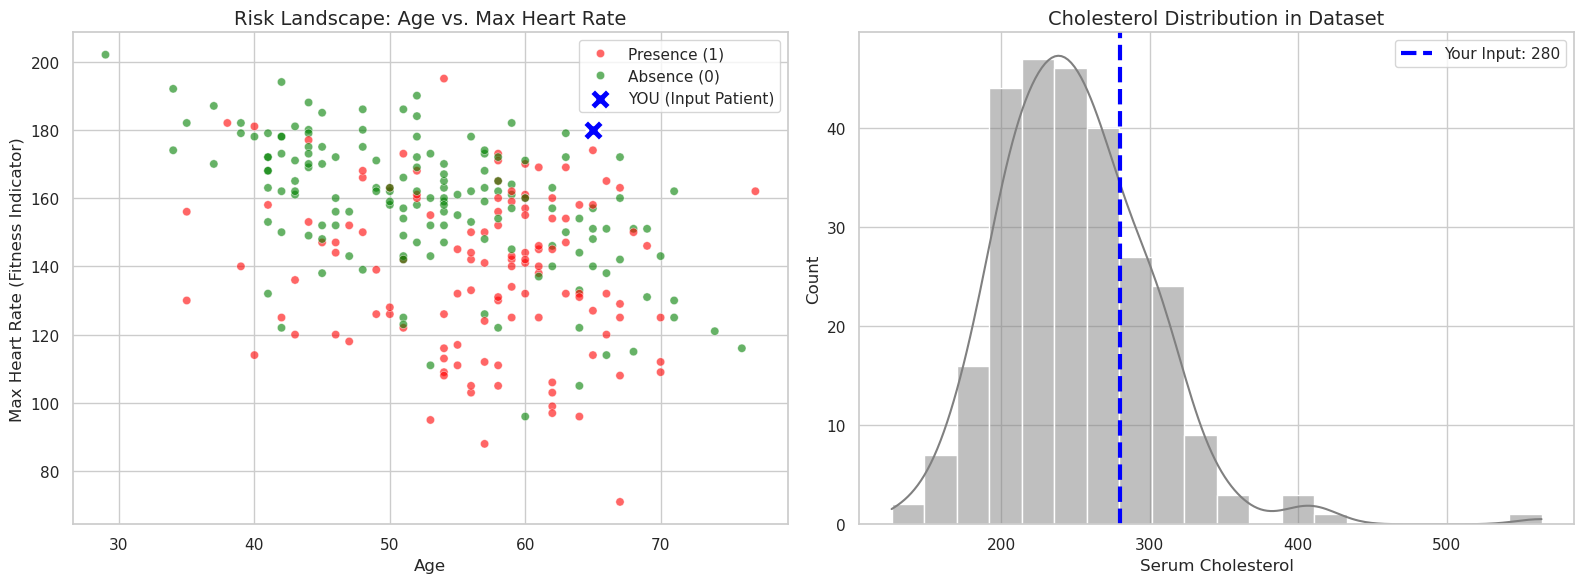

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('heart.csv')

# Map heart_disease to 0 (Absent) and 1 (Present) for visualization
df['diagnosis'] = df['heart_disease'].map({1: 'Absence (0)', 2: 'Presence (1)'})

# User's input data point
user_age = 65
user_max_hr = 180
user_chol = 280

# Set plot style
sns.set_theme(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Age vs Max Heart Rate (Scatter)
sns.scatterplot(
    data=df, x='age', y='max_heart_rate', hue='diagnosis', 
    palette={'Absence (0)': 'green', 'Presence (1)': 'red'}, 
    alpha=0.6, ax=axes[0]
)
# Highlight the user's point
axes[0].scatter(user_age, user_max_hr, color='blue', s=250, marker='X', label='YOU (Input Patient)', edgecolors='white', linewidth=2)
axes[0].set_title('Risk Landscape: Age vs. Max Heart Rate', fontsize=14)
axes[0].set_xlabel('Age', fontsize=12)
axes[0].set_ylabel('Max Heart Rate (Fitness Indicator)', fontsize=12)
axes[0].legend()

# Plot 2: Cholesterol Distribution (Histogram)
sns.histplot(df['serum_cholestoral'], bins=20, kde=True, color='gray', ax=axes[1])
# Highlight the user's cholesterol level
axes[1].axvline(user_chol, color='blue', linestyle='--', linewidth=3, label=f'Your Input: {user_chol}')
axes[1].set_title('Cholesterol Distribution in Dataset', fontsize=14)
axes[1].set_xlabel('Serum Cholesterol', fontsize=12)
axes[1].legend()

plt.tight_layout()
plt.savefig('clinical_landscape.png')

print("Visual analysis generated.")